# Lagrangian trajectories in the Gulf Stream area

This is a first exploration.


In [1]:
# import libraries

%matplotlib inline
from glob import glob
import re
#from netCDF4 import Dataset
#import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cartopy.crs as ccrs
import gsw

from clib.flow import *

In [2]:
# load grid info
grd = grid()

# output files
ofiles = sorted(glob(grd._datadir+'*avg*.nc'))

ds = xr.open_mfdataset(ofiles, concat_dim='time', compat='equals')
print(ds)

1 grid file found, uses: /home/datawork-lops-osi/jgula/NESED/nesea_grd.nc
-- Grid object
dim lon_rho: 1602  2002
lon_rho min= -72.123, max=-58.273
lat_rho min= 34.123, max=43.734
h min= 20.000, max=5543.070
<xarray.Dataset>
Dimensions:     (auxil: 4, eta_rho: 1602, eta_v: 1601, s_rho: 50, s_w: 51, time: 1300, xi_rho: 2002, xi_u: 2001)
Coordinates:
  * time        (time) float64 6.48e+07 6.481e+07 6.481e+07 6.481e+07 ...
Dimensions without coordinates: auxil, eta_rho, eta_v, s_rho, s_w, xi_rho, xi_u
Data variables:
    time_step   (time, auxil) int32 dask.array<shape=(1300, 4), chunksize=(20, 4)>
    scrum_time  (time) float32 dask.array<shape=(1300,), chunksize=(20,)>
    zeta        (time, eta_rho, xi_rho) float32 dask.array<shape=(1300, 1602, 2002), chunksize=(20, 1602, 2002)>
    ubar        (time, eta_rho, xi_u) float32 dask.array<shape=(1300, 1602, 2001), chunksize=(20, 1602, 2001)>
    vbar        (time, eta_v, xi_rho) float32 dask.array<shape=(1300, 1601, 2002), chunksize=(20, 1

In [3]:
ldatadir = '/home/datawork-lops-osi/jgula/Cognac/north/'
lfiles = sorted(glob(ldatadir+'*.nc'))

# open files
lds = [xr.open_dataset(file) for file in lfiles]
print(lds[0])

dt_particles = lds[0].ocean_time[1]-lds[0].ocean_time[0]
print('dt_particles = %.1f' %dt_particles)

depth = [-l.depth for l in lds]
print('depth of different simulations:' , depth)

# convert list of datasets into a dict of datasets
lds = dict(zip(depth,lds))

# conmpute the offset between ds.time and lds.ocean_time
dt = find_dt(lds[0], ds, ofiles)
# ds.time/86400. = (d.ocean_time+dt)/86400.

<xarray.Dataset>
Dimensions:     (nq: 10037, time: 360)
Coordinates:
  * time        (time) float32 60.0 61.0 62.0 63.0 64.0 65.0 66.0 67.0 68.0 ...
Dimensions without coordinates: nq
Data variables:
    ocean_time  (time) float32 ...
    px          (time, nq) float64 ...
    py          (time, nq) float64 ...
    pt          (time, nq) float64 ...
    ps          (time, nq) float64 ...
    pu          (time, nq) float64 ...
    pv          (time, nq) float64 ...
    plon        (time, nq) float64 ...
    plat        (time, nq) float64 ...
    ptopo       (time, nq) float64 ...
    prho        (time, nq) float64 ...
    prho1       (time, nq) float64 ...
Attributes:
    description:  particles tracking
    simulation:   nesed_avg [0,10000,0,10000,[1,100,1]] 60
    sub:          360
    base:         0
    ng:           1
    x_periodic:   0
    y_periodic:   0
    depth:        0
dt_particles = 3600.0
depth of different simulations: [0, 50, 100, 200, 300, 400, 500]


In [4]:
# useful parameters

# initial mass center
lon0, lat0 = lds[0].plon.isel(time=0).mean().values, lds[0].plat.isel(time=0).mean().values
# metric terms
dlon = 111.e3 * np.cos(np.pi/180.*lat0)
dlat = 111.e3

nq = {}
for d in [2, 5, 10, 20]:
    sources = []
    sources.append([-d*1.e3, -d*1.e3])
    sources.append([-d*1.e3, d*1.e3])
    sources.append([d*1.e3, d*1.e3])
    sources.append([d*1.e3, -d*1.e3])
    nq[d] = np.array([get_nq( lds[0], lon0+s[0]/dlon, lat0+s[1]/dlat ) for s in sources])

# colors
cols = cm.plasma(np.linspace(0,1,len(nq)))
cols = dict(zip(nq.keys(),[cols[i,:] for i in range(cols.shape[0])]))

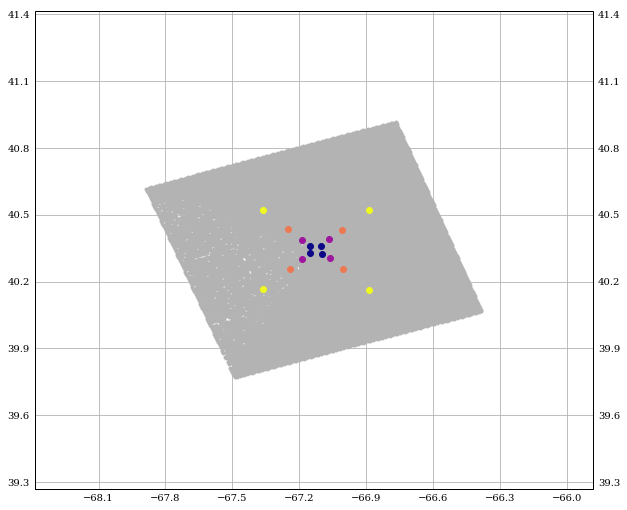

In [5]:
crs = ccrs.PlateCarree()

fig=plt.figure(figsize=(10,10))
#
ax=plt.axes(projection=crs)
ax.set_extent(get_hextent(lds[0].isel(time=0)), crs)
#ax.set_extent([-68.4, -65.8, 39.6, 41.], crs)
gl=ax.gridlines(crs=crs,draw_labels=True)
gl.xlabels_top = False
ax.coastlines(resolution='50m')
#

l = lds[0].isel(time=0)
ax.plot(l.plon,l.plat,'.', color='.7', transform=crs)

for d in nq:
    ax.plot(l.plon.isel(nq=nq[d]), l.plat.isel(nq=nq[d]), 'o', color=cols[d])


---

## Initial position

Text(0.5,1,'surface temperature [degC]')

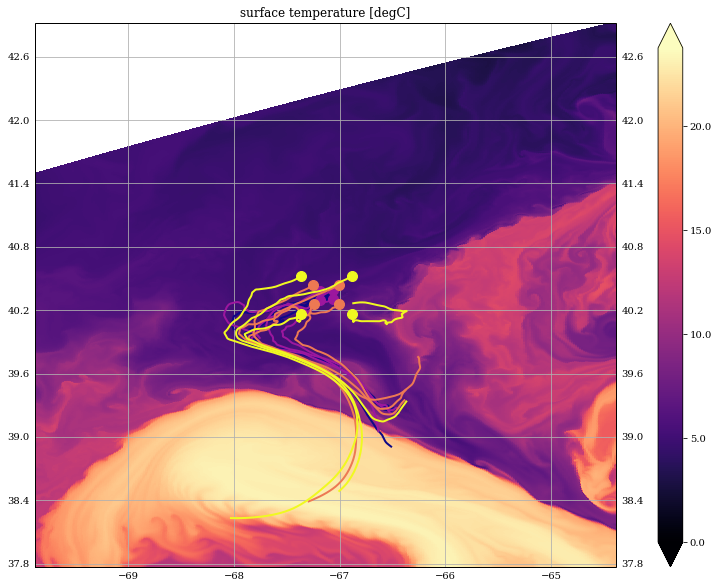

In [6]:
crs = ccrs.PlateCarree()

fig=plt.figure(figsize=(15,10))
#
ax=plt.axes(projection=crs)
#ax.set_extent(grd.hextent, crs)
ax.set_extent(get_hextent(lds[0].isel(time=0), dlon=2., dlat=2.), crs)
gl=ax.gridlines(crs=crs,draw_labels=True)
gl.xlabels_top = False
ax.coastlines(resolution='50m')
#
iz = -1
ilon = int(grd.Lp/2)  # used for vertical slices
toplt = ds['temp'].isel(time=0, s_rho=iz).values
# should probably mask T
cmap = plt.get_cmap('magma')
im = ax.pcolormesh(grd['lon_rho'],grd['lat_rho'], toplt,
                   vmin=toplt.min(),vmax=toplt.max(), 
                   cmap=cmap, transform=crs)
cbar = plt.colorbar(im, format='%.1f', extend='both')


for d in [2, 5, 10, 20]:
    l = lds[0].isel(nq=nq[d]).isel(time=slice(0,24*10))
    ax.plot(l.plon.isel(time=0),l.plat.isel(time=0),'o', color=cols[d], markersize=10, transform=crs)
    ax.plot(l.plon,l.plat, color=cols[d], lw=2, transform=crs)

#l = lds[0].isel(nq=nq[10]).isel(time=slice(0,24*10))
#ax.plot(l.plon.isel(time=0),l.plat.isel(time=0),'o', color='0.5', transform=crs)
#ax.plot(l.plon,l.plat, color='0.5', transform=crs)

ax.set_title('surface temperature [degC]')

#plt.savefig('figs/T_hmap.png',dpi=300)

---

## Spreading


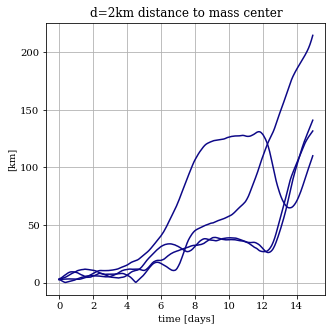

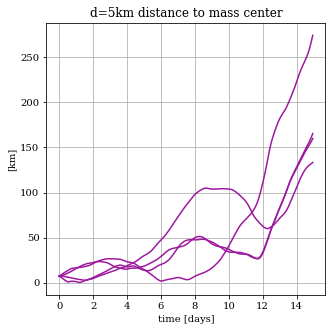

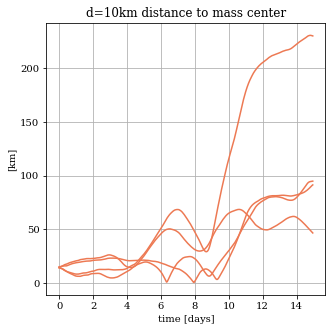

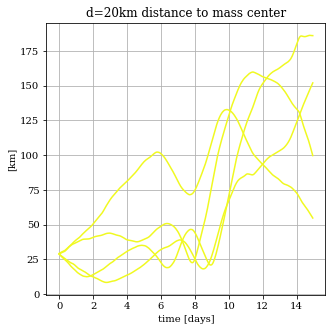

In [7]:
for d in nq:

    l = lds[0].isel(nq=nq[d])
    mp = l.mean(dim='nq')
    d_to_mp = 111.e3 *np.sqrt( np.sin(np.pi/180.*mp.plat) * (l.plon-mp.plon)**2 + (l.plat-mp.plat)**2 )
    #d = d.assign_coords(ti=(l.ocean_time-l.ocean_time[0])/86400.)
    #print(d)

    fig=plt.figure(figsize=(5,5))
    #
    ax=plt.subplot(111)

    ti = (l.ocean_time-l.ocean_time[0])/86400.
    ax.plot(ti, d_to_mp/1e3, color=cols[d])
    ax.set_xlabel('time [days]')
    ax.set_title('d=%dkm distance to mass center'%d)
    ax.set_ylabel('[km]')
    ax.grid()